In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run Mask-Utils.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
TEXTURE_SIZE = 400

In [4]:
face_boxes, tddfa = load_models()
predictor = get_vertices_predictor(face_boxes, tddfa)

___

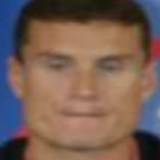

In [5]:
from skimage.io import imread

# test_image_url = 'https://avatars.mds.yandex.net/get-kinopoisk-post-img/2423210/6fa756128b42aa4553fd3f64339b2748/960x540'
# test_image_url = 'https://i.pinimg.com/736x/ce/1a/d0/ce1ad006c5969585e2bc0609a9981dae.jpg'
test_image_url = 'https://upload.wikimedia.org/wikipedia/commons/6/6c/Lionel_Messi_in_2018.jpg'
# test_image_url = 'https://previews.123rf.com/images/bowie15/bowie151310/bowie15131000036/22756898-screaming-shouting-man.jpg'
# test_image_url = 'https://westcottu.com/wp-content/uploads/robert_close.jpg'
# test_image_url = 'https://cdn.profoto.com/cdn/0521445/contentassets/b61cf60b567f46ac9a274c3f87a5bcb1/portrait_technique_0002.jpg'
# test_image_url = 'https://as1.ftcdn.net/jpg/02/54/74/14/500_F_254741496_XqAP4hpIpL2miUfziPBEXvxsFTMzr3PE.jpg'
# test_image_url = 'https://i.etsystatic.com/15323487/d/il/b394b9/2610037605/il_340x270.2610037605_c2hz.jpg?version=0'
# test_image_url = 'https://i.pinimg.com/originals/b1/d4/b8/b1d4b854b2aa9fe9b6884a2bd8e11125.jpg'
# test_image_url = 'https://www.hopkinsmedicalproducts.com/images/xxl/Medical-Grade-Mask.jpg'
# test_image_url = 'https://images-na.ssl-images-amazon.com/images/I/719krZoENLL._AC_SY679_.jpg'
# test_image_url = 'https://www.meaok.com/media/catalog/product/cache/1c79e4ec97fce480fc1866d4e428246e/p/f/pf07375_pri03.jpg'

test_image = cv2.imread('/home/darusik/datasets/lfw/lfw_mtcnnpy_160/David_Coulthard/David_Coulthard_0001.png')
# test_image = np.ascontiguousarray(imread(test_image_url)[..., ::-1])
imshow(test_image)

In [6]:
ver = predictor(test_image)
ver

array([[ 35.877487 ,  35.91482  ,  35.954727 , ..., 135.20572  ,
        135.15152  , 135.09134  ],
       [ 54.207027 ,  54.417477 ,  54.627415 , ..., 113.83915  ,
        113.5884   , 113.33618  ],
       [ 60.4261   ,  60.41488  ,  60.402534 , ...,   3.6022873,
          2.963646 ,   2.3234863]], dtype=float32)

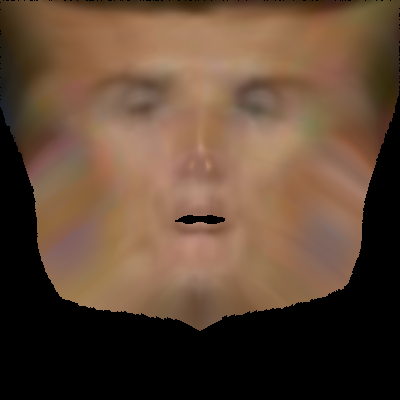

In [7]:
texture = uv_tex(test_image, [ver], tddfa.tri, uv_h=TEXTURE_SIZE, uv_w=TEXTURE_SIZE)
imshow(texture)

In [8]:
uv_coords = get_uv_coords(TEXTURE_SIZE)
uv_coords.shape

(38365, 3)

In [9]:
uv2ver_sparse = get_sparse_uv2ver(uv_coords, TEXTURE_SIZE)

In [10]:
# dense
uv2ver = inpaint(uv2ver_sparse,
                 mask=np.isnan(uv2ver_sparse).astype(np.uint8),
                 interpolator_cls=interpolate.LinearNDInterpolator)

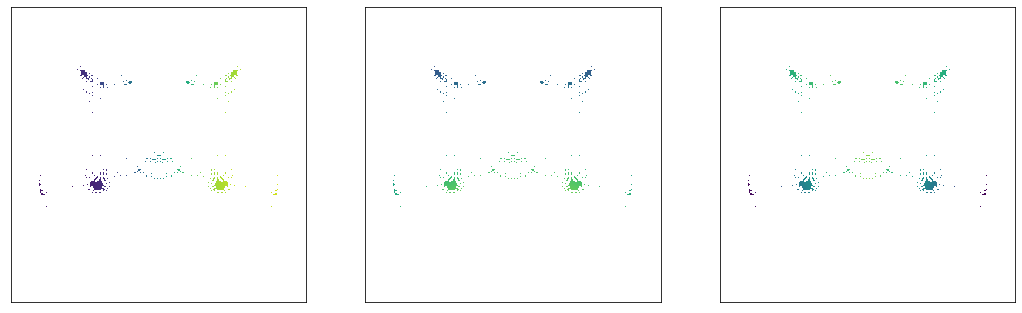

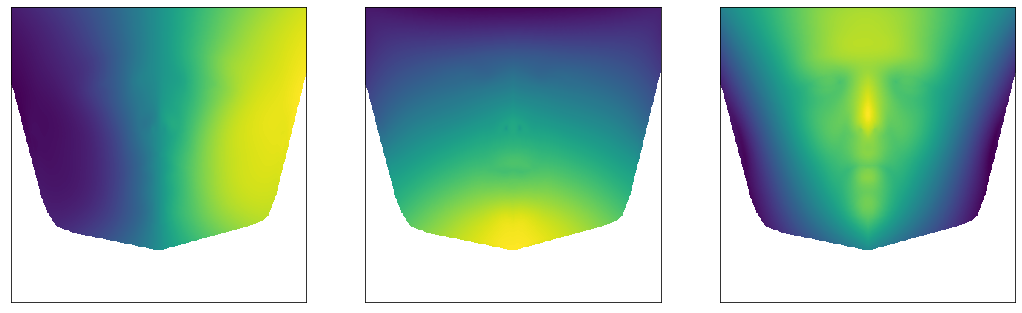

In [11]:
show_channelwise(uv2ver_sparse)
show_channelwise(uv2ver)

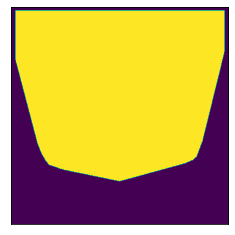

In [12]:
face_indicator = get_face_indicator(uv2ver)
pltshow(face_indicator)

In [13]:
convex_uv2ver_sparse = get_almost_convex_sparse_uv2ver(ver, uv2ver, face_indicator)

In [14]:
convex_uv2ver = inpaint(convex_uv2ver_sparse,
                        mask=np.isnan(convex_uv2ver_sparse).astype(np.uint8),
                        interpolator_cls=LinearNDInterpolatorExt)

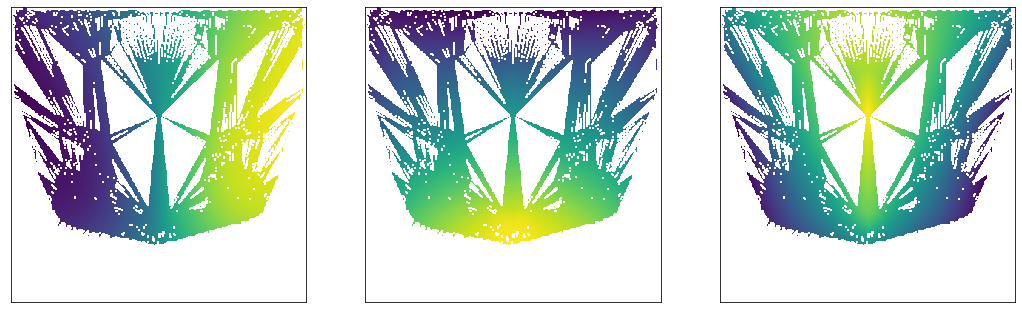

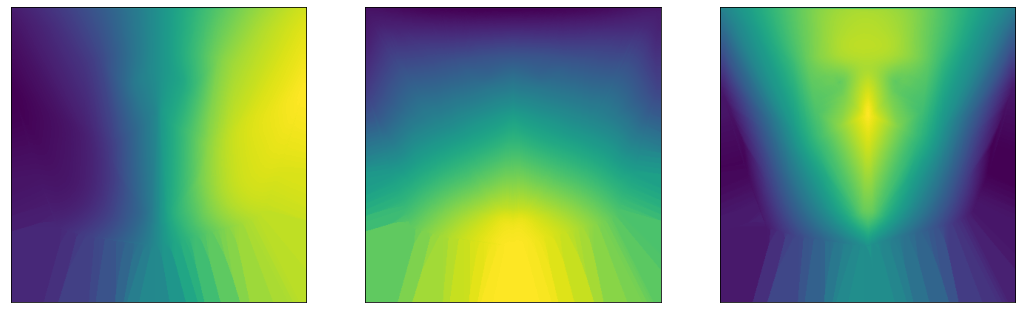

In [15]:
show_channelwise(convex_uv2ver_sparse)
show_channelwise(convex_uv2ver)

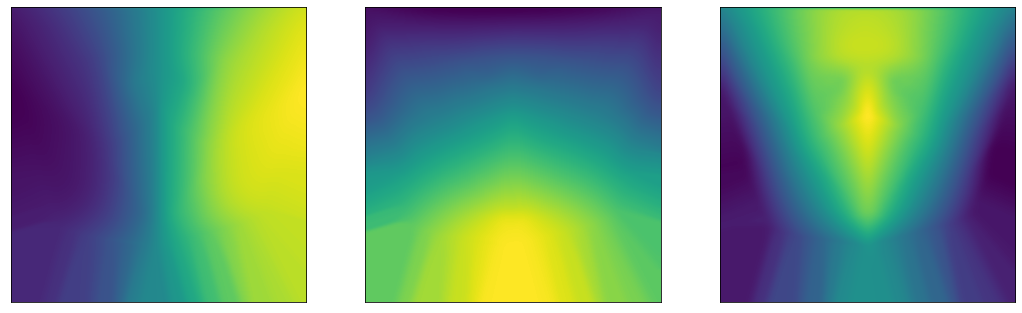

In [16]:
blurred_convex_uv2ver = blur_multichannel(convex_uv2ver, sigma=(1.5, 5.0), mode='nearest')
show_channelwise(blurred_convex_uv2ver)

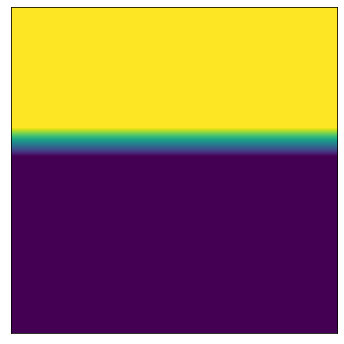

In [17]:
blur_mix_weights = get_blur_weights(convex_uv2ver.shape)[..., None]
show_channelwise(blur_mix_weights)

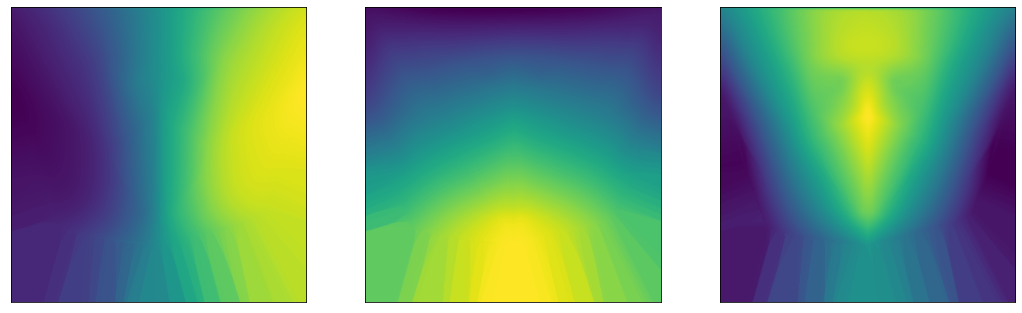

In [18]:
convex_uv2ver = convex_uv2ver * (1.0 - blur_mix_weights) + blurred_convex_uv2ver * blur_mix_weights
show_channelwise(convex_uv2ver)

In [19]:
convex_mesh = get_mesh(convex_uv2ver, face_indicator, TEXTURE_SIZE, TEXTURE_SIZE)

___

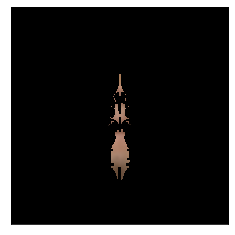

In [20]:
visible_skin = get_visible_skin(uv2ver)
pltshow(np.where(visible_skin[..., None] == 1, texture / 255.0, np.nan))

In [21]:
target_lightness_ratio = get_cheeks_lightness_ratio(texture, visible_skin)
target_lightness_ratio

-0.020575881004333496

In [22]:
light_x = find_light_x_position(
    target_lightness_ratio,
    uv_coords, ver, tddfa.tri, texture, visible_skin,
    render_app, test_image.shape,
)
light_x

0.0

___

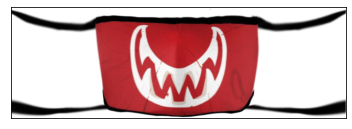

In [23]:
from random import choice

facecover_path = choice(['flat_mask.png',
                         'flat_mask_circular.png',
                         'flat_mask_slipknot.png',
                         'flat_mask_white.png',
                         'flat_mask_green.png',
                         'flat_mask_red.png',
                         'flat_mask_black.png',
                         ])

facecover_texture = cv2.imread(facecover_path, cv2.IMREAD_UNCHANGED).astype(np.float32) / 255.0
pltshow(facecover_texture)

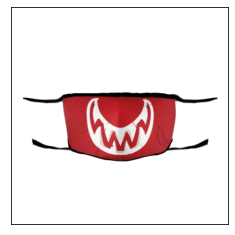

In [24]:
facecover = FacecoverTextureWarper()(facecover_texture, texture.shape[0])
pltshow(facecover)

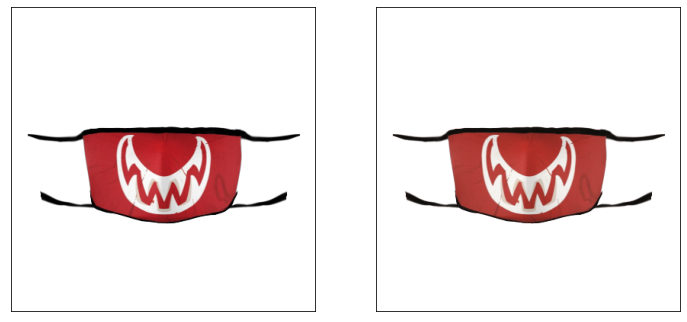

In [25]:
facecover_tr = facecover_color_transfer(facecover, texture)
show_channelwise([facecover, facecover_tr])

In [26]:
update_colors(convex_mesh, facecover_tr)

In [27]:
ambient_w, direct_w = get_lightning_params(target_lightness_ratio, light_x, facecover_tr)
ambient_w, direct_w

(0.47938187329986975, 0.4892455776805224)

In [28]:
facecover_render, alpha_render, prefinal_render, final_render = render_facecover(
    render_app, convex_mesh, test_image, light_x, ambient_w, direct_w, return_intermediate=True
)

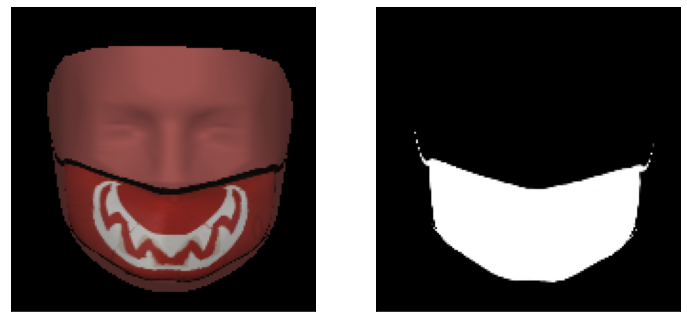

In [29]:
show_channelwise([facecover_render / 255.0, alpha_render ])

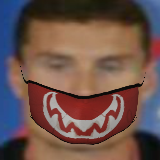

In [30]:
imshow(prefinal_render)

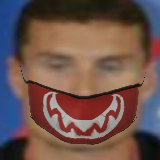

In [31]:
imshow(final_render)